In [ ]:
###################
#for each initial state the distance is calculated
#with a fixed error configuration
###################

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import qiskit.quantum_info as qi
from qiskit.visualization import plot_state_qsphere
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.visualization import plot_histogram
from qiskit import execute, transpile, assemble
from qiskit import Aer
from numpy import pi
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
print("Import Successfully")

Import Successfully


In [3]:
# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer import AerSimulator
print("Import Successfully")

Import Successfully


[1, 0, 0, 0, 0, 0, 0, 0] [0j]
[0, 1, 0, 0, 0, 0, 0, 0] [(1.0390555919826106e-16+9.535726367485356e-18j)]
[0, 0, 1, 0, 0, 0, 0, 0] [0j]
[0, 0, 0, 1, 0, 0, 0, 0] [(8.715763992105247e-33+0j)]
[0, 0, 0, 0, 1, 0, 0, 0] [0j]
[0, 0, 0, 0, 0, 1, 0, 0] [(6.351157409075596e-17+0j)]
[0, 0, 0, 0, 0, 0, 1, 0] [0j]
[0, 0, 0, 0, 0, 0, 0, 1] [(5.712572157733055e-17-1.3485553555976518e-17j)]


C:\Users\giuli\anaconda3\envs\quiskit\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)




Distanza media = (2.806785685829345e-17-4.937283985613953e-19j)


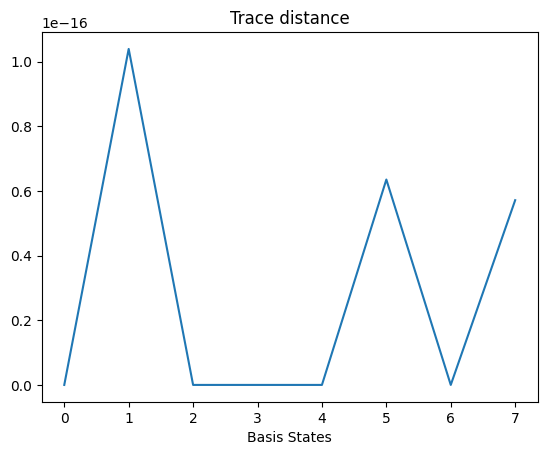

In [56]:
#FUNZIONI PER CIRCUITO IDEALE
def qft_rotations_ideal(circuit, n):
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    qft_rotations_ideal(circuit, n)

def swap_registers_ideal(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft_ideal(circuit, n):
    qft_rotations_ideal(circuit, n)
    swap_registers_ideal(circuit, n)
    return circuit

#FUNZIONI PER CIRCUITO NOISY
def qft_rotations(circuit, n):
    if n == 0:
        return circuit
    n -= 1
    
    epsilon = 1                          #--------------------------------------------NOISE-4
    extracted = random.uniform(0, 1)
    if (extracted < epsilon):    
        circuit.z(0)   
    
    circuit.h(n)   
    
    #epsilon = 1                          #--------------------------------------------NOISE-5
    #extracted = random.uniform(0, 1)
    #if (extracted < epsilon):    
    #    circuit.x(3) 
        
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
        
def qft(circuit, n):
    #epsilon = 1                          #--------------------------------------------NOISE-1
    #extracted = random.uniform(0, 1)
    #if (extracted < epsilon):    
    #    circuit.x(3)  

    qft_rotations(circuit, n)
    
    #epsilon = 1                          #--------------------------------------------NOISE-2
    #extracted = random.uniform(0, 1)
    #if (extracted < epsilon):    
    #    circuit.z(3) 
    
    swap_registers(circuit, n)    
    
    #epsilon = 1                          #--------------------------------------------NOISE-3
    #extracted = random.uniform(0, 1)
    #if (extracted < epsilon):    
    #    circuit.z(3) 

    return circuit

###########################################################


qubits = 3                      #dimensione sistema
label = [0]*(2**qubits)
register = QuantumRegister(qubits)
risultato = []
distanze = []


for iii in range(len(label)):   #ciclo sugli stati iniziali
    label[iii] = 1
    state = Statevector(label)
    
    # circuito ideale
    qc_ideal = QuantumCircuit(register) 
    qc_ideal.initialize(state.data, register)
    qft_ideal(qc_ideal,qubits)
    qc_ideal.save_density_matrix()
    #qc_ideal.measure_all()
    
    #simulazione ideale
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc_ideal, aer_sim)
    qobj = assemble(t_qc)                                
    results = aer_sim.run(qobj, shots = 1).result()
    
    density_matrix_ideal = 0
    density_matrix_ideal = results.data().get('density_matrix')
    density_matrix_ideal = np.asarray(density_matrix_ideal)
    #print(density_matrix_ideal)

    runs = 1
    for i in range(runs):         
        
        #circuito noisy
        qc_noisy = QuantumCircuit(register)
        qc_noisy.initialize(state, register)
        
        qft(qc_noisy,qubits)
        qc_noisy.save_density_matrix()
        #qc_ideal.measure_all()

        #simulazione noisy
        aer_sim = Aer.get_backend('aer_simulator')
        t_qc = transpile(qc_noisy, aer_sim)
        qobj = assemble(t_qc)                                
        results = aer_sim.run(qobj, shots = 1).result()

        #estrazione matrice densità
        density_matrix = 0
        density_matrix = results.data().get('density_matrix')
        density_matrix = np.asarray(density_matrix)

        #calcolo della distanza
        diff = density_matrix - density_matrix_ideal
        mult = np.matmul(np.transpose(diff), diff)
        rad = np.sqrt(mult)
        distanze.append(rad.trace()/2)

        print(label, distanze)
        risultato.append(distanze[0])
        label[iii] = 0
        distanze = []

plt.title('Trace distance')
plt.xlabel('Basis States')
plt.plot(risultato)
#plt.savefig('distances_c5_x0.pdf', format = 'pdf') 

media = sum(risultato)/(2**qubits)
print('\n')
print('Distanza media =',  media)
